In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.cloud import bigquery
from google.oauth2 import service_account
from math import sqrt
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_name = 'carol-0483dfa91ba54cd4b97b.0483dfa91ba54cd4b97b1613f1171932'
model_name = 'demand_forecast'

In [ ]:
SA_FILEPATH = "/content/drive/MyDrive/Insight Estoque/service_account_unif.json"

credentials = service_account.Credentials.from_service_account_file(
    SA_FILEPATH, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### Demanda

### Mensal:

*   7a3fc1c7cf380cf3795e9f0fafe198e6
*   1f259b5bbb94a164dc0ab4341e1c3302
*   015966688b119a085ee7d3368c8aec8a
*   1e8aef1957a1cafb54ab17c9c8cf7e3f
*   62a53836e79b6f5bc777b90b0b4f5fd4

### Semanal:

*   10853440fcd9643bc68ff697f75e1430
*   24b5d35815b58bc2a20186b4e8ffa124
*   a5414e261c2101edd88f939e2a08785c
*   614b4a044c315c36f17b8dfb5295c29f
*   2fe5a07b52d2052385a4475cf665078b

### Diario:

*   94b30f4ae1596e410ab3b4573fa69601
*   84267644f7c73158e6765b4a9c71c026
*   498bc264b482508495fe197f2ffe98da
*   4cfc8d3e52d010bf24911e896a86ecee
*   2f08c995771ded0ee90933719ba1c1fc




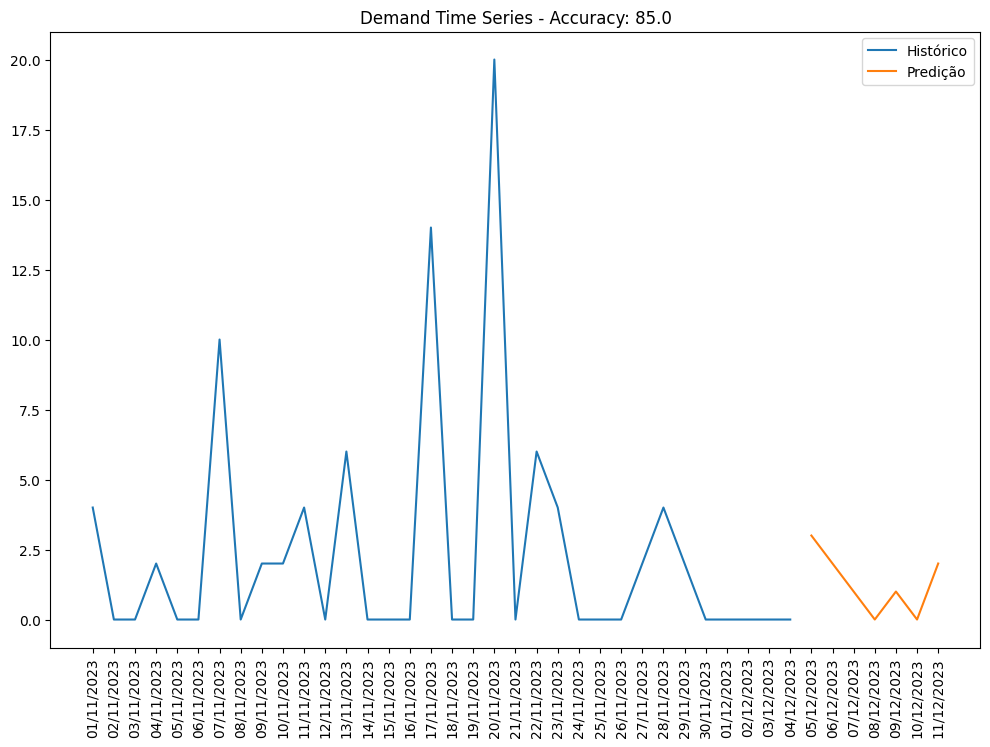

In [ ]:
query = """
        SELECT *
        FROM `{0}.deduplicated_demandgraph`
        WHERE id = '2f08c995771ded0ee90933719ba1c1fc' AND frequency = 'D'
        """.format(project_name)


df_train = client.query(query).to_dataframe()


df_pred = df_train[df_train['prediction']][['initial_reference_date', 'pb_value']]
df_hist = df_train[~df_train['prediction']][['initial_reference_date', 'pb_value']]

df_pred.sort_values(by=['initial_reference_date'], inplace=True)
df_hist.sort_values(by=['initial_reference_date'], inplace=True)

df_pred['initial_reference_date'] = df_pred['initial_reference_date'].dt.strftime('%d/%m/%Y')
df_hist['initial_reference_date'] = df_hist['initial_reference_date'].dt.strftime('%d/%m/%Y')

accuracy = df_train[df_train['prediction']].iloc[0]['accuracy']


plt.figure(figsize=(12,8))
plt.plot(df_hist.initial_reference_date, df_hist.pb_value, label='Histórico')
plt.plot(df_pred.initial_reference_date, df_pred.pb_value, label='Predição')
plt.legend(loc='best')
plt.title(f"Demand Time Series - Accuracy: {accuracy}")
plt.xticks(rotation=90)
plt.show()

### Ruptura

### Mensal:

*   6fa41dcc8cf85f730c69d6096d1f46eb
*   48a7b965b0449b5e12946b00e621e2af
*   e8b8e6e409c99905b10d575b9bd071d1
*   4302cc63ec3a294e71803274c02d39cd
*   99e167a09d71ed60e2800b05eb10c454

### Semanal:

*   9c686895510a1fe3d79e485c80af071b
*   bea5f9713a941e74257ca31c0c078542
*   8dd3bd724c594428938abe509d72df89
*   fcd0e717b85c3466a273cefbf9712048
*   3f083549b4b72d8bcfd6f3c212e8d8bd

### Diario:

*   bea5f9713a941e74257ca31c0c078542
*   724ac5ec9ece4a68b69e29dbea716279
*   94b30f4ae1596e410ab3b4573fa69601
*   b123e8ea683ee349be8f4e1085790caf
*   2b86ef8a63f702aaa59dc397817908b6

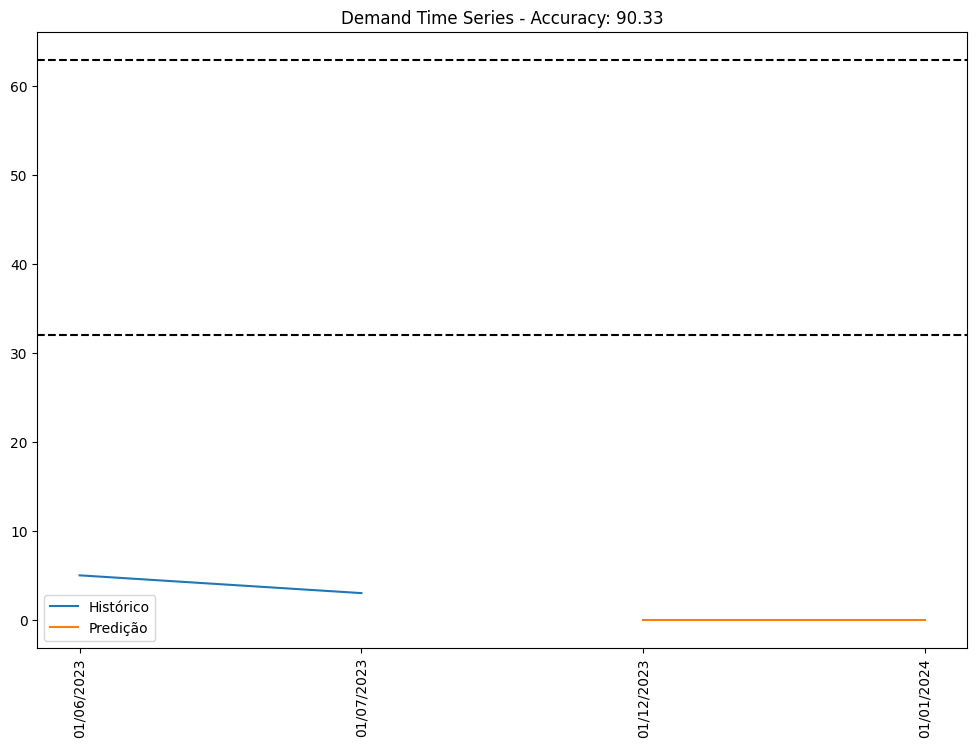

In [ ]:
query = """
        SELECT *
        FROM `{0}.deduplicated_rupturegraph` rg

        LEFT JOIN `{0}.deduplicated_rupturealert` ra
        ON rg.id = ra.id AND rg.frequency = ra.frequency

        WHERE rg.id = '23295d656b7743e346876093a96f6042' AND rg.frequency = 'M'
        """.format(project_name)


df_train = client.query(query).to_dataframe()


df_pred = df_train[df_train['prediction']][['initial_reference_date', 'pb_value']]
df_hist = df_train[~df_train['prediction']][['initial_reference_date', 'pb_value']]

df_pred.sort_values(by=['initial_reference_date'], inplace=True)
df_hist.sort_values(by=['initial_reference_date'], inplace=True)

df_pred['initial_reference_date'] = df_pred['initial_reference_date'].dt.strftime('%d/%m/%Y')
df_hist['initial_reference_date'] = df_hist['initial_reference_date'].dt.strftime('%d/%m/%Y')

accuracy = df_train[df_train['prediction']].iloc[0]['accuracy']
replenishment = df_train.iloc[0]['replenishment']
safety_stock = df_train.iloc[0]['safety_stock']


plt.figure(figsize=(12,8))
plt.plot(df_hist.initial_reference_date, df_hist.pb_value, label='Histórico')
plt.plot(df_pred.initial_reference_date, df_pred.pb_value, label='Predição')
plt.axhline(y=replenishment, color="black", linestyle="--")
plt.axhline(y=safety_stock, color="black", linestyle="--")
plt.legend(loc='best')
plt.title(f"Demand Time Series - Accuracy: {accuracy}")
plt.xticks(rotation=90)
plt.show()

### Financeiro

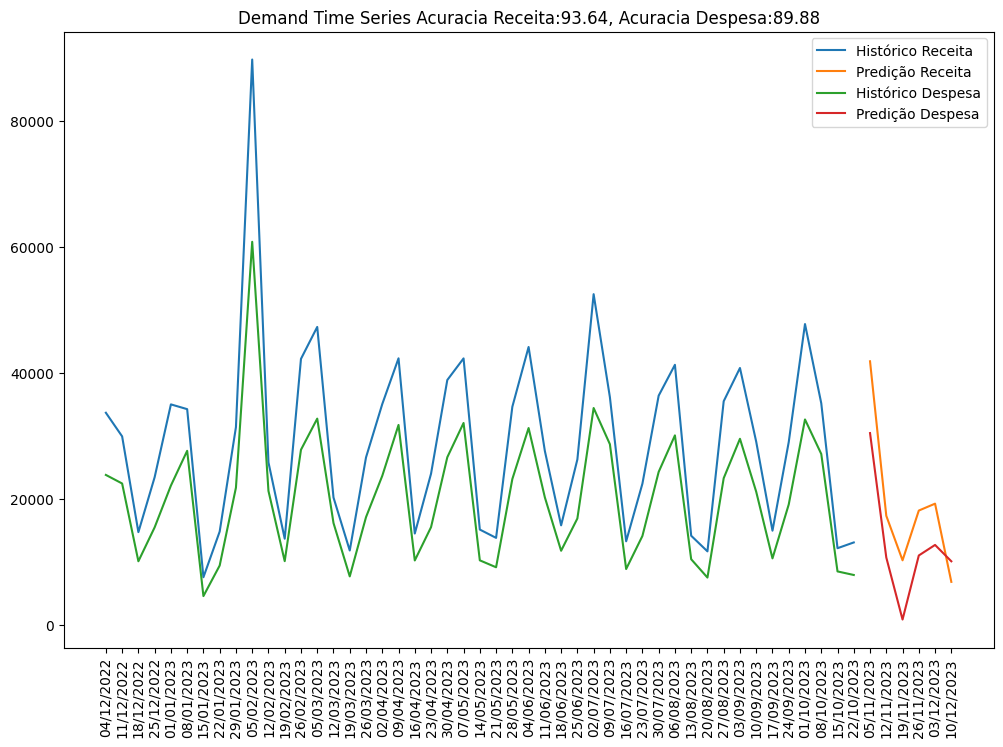

In [ ]:
query = """
        SELECT *
        FROM `{0}.deduplicated_forecastfinancial`
        WHERE tenantid = '5063472056c14860b7b4b8de90a58065' AND frequency = 'w'
              AND company_group = '01' AND branch = '010108'
        """.format(project_name)


df_train = client.query(query).to_dataframe()


df_pred_R = df_train[(df_train['prediction']) & (df_train['type']=='r')][['initial_reference_date', 'pb_value']]
df_hist_R = df_train[(~df_train['prediction']) & (df_train['type']=='R')][['initial_reference_date', 'pb_value']]
df_pred_P = df_train[(df_train['prediction']) & (df_train['type']=='p')][['initial_reference_date', 'pb_value']]
df_hist_P = df_train[(~df_train['prediction']) & (df_train['type']=='P')][['initial_reference_date', 'pb_value']]

df_pred_R.sort_values(by=['initial_reference_date'], inplace=True)
df_hist_R.sort_values(by=['initial_reference_date'], inplace=True)
df_pred_P.sort_values(by=['initial_reference_date'], inplace=True)
df_hist_P.sort_values(by=['initial_reference_date'], inplace=True)

df_pred_R['initial_reference_date'] = df_pred_R['initial_reference_date'].dt.strftime('%d/%m/%Y')
df_hist_R['initial_reference_date'] = df_hist_R['initial_reference_date'].dt.strftime('%d/%m/%Y')
df_pred_P['initial_reference_date'] = df_pred_P['initial_reference_date'].dt.strftime('%d/%m/%Y')
df_hist_P['initial_reference_date'] = df_hist_P['initial_reference_date'].dt.strftime('%d/%m/%Y')

accuracyR = df_train[(df_train['prediction']) & (df_train['type']=='r')].iloc[0]['accuracy']
accuracyP = df_train[(df_train['prediction']) & (df_train['type']=='p')].iloc[0]['accuracy']

plt.figure(figsize=(12,8))
plt.plot(df_hist_R.initial_reference_date, df_hist_R.pb_value, label='Histórico Receita')
plt.plot(df_pred_R.initial_reference_date, df_pred_R.pb_value, label='Predição Receita')
plt.plot(df_hist_P.initial_reference_date, df_hist_P.pb_value, label='Histórico Despesa')
plt.plot(df_pred_P.initial_reference_date, df_pred_P.pb_value, label='Predição Despesa')
plt.legend(loc='best')
plt.title(f"Demand Time Series Acuracia Receita:{accuracyR}, Acuracia Despesa:{accuracyP}")
plt.xticks(rotation=90)
plt.show()